# Loop 1 Analysis: Understanding the Optimization Landscape

## Key Questions:
1. What is the score breakdown by N value?
2. Where are the biggest opportunities for improvement?
3. What approaches haven't been tried yet?

In [6]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

# Christmas tree polygon vertices
TREE_VERTICES = np.array([
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5),
])

def load_submission(filepath):
    df = pd.read_csv(filepath)
    for col in ['x', 'y', 'deg']:
        df[col] = df[col].astype(str).str.replace('s', '', regex=False).astype(float)
    return df

def get_trees_for_n(df, n):
    prefix = f"{n:03d}_"
    return df[df['id'].str.startswith(prefix)]

def get_bounding_box_side(trees_df):
    if len(trees_df) == 0:
        return 0
    all_points = []
    for _, row in trees_df.iterrows():
        base = Polygon(TREE_VERTICES)
        rotated = rotate(base, row['deg'], origin=(0, 0))
        translated = translate(rotated, row['x'], row['y'])
        coords = np.array(translated.exterior.coords)
        all_points.append(coords)
    all_points = np.vstack(all_points)
    min_xy = all_points.min(axis=0)
    max_xy = all_points.max(axis=0)
    return max(max_xy - min_xy)

print('Functions defined')

Functions defined


In [7]:
# Load the best submission
best_path = '/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/ensemble.csv'
df = load_submission(best_path)
print(f'Loaded {len(df)} rows')

Loaded 20100 rows


In [8]:
# Calculate score breakdown by N
scores_by_n = []
for n in range(1, 201):
    trees = get_trees_for_n(df, n)
    side = get_bounding_box_side(trees)
    score_contribution = side**2 / n
    scores_by_n.append({
        'n': n,
        'side': side,
        'score_contribution': score_contribution,
        'cumulative_score': sum([s['score_contribution'] for s in scores_by_n]) + score_contribution
    })

scores_df = pd.DataFrame(scores_by_n)
print(f'Total score: {scores_df["score_contribution"].sum():.6f}')
print(f'Target score: 68.919154')
print(f'Gap: {scores_df["score_contribution"].sum() - 68.919154:.6f}')

Total score: 70.676102
Target score: 68.919154
Gap: 1.756948


In [9]:
# Analyze score contribution by N ranges
print('Score contribution by N range:')
for start, end in [(1, 10), (11, 50), (51, 100), (101, 150), (151, 200)]:
    range_df = scores_df[(scores_df['n'] >= start) & (scores_df['n'] <= end)]
    total = range_df['score_contribution'].sum()
    print(f'  N={start}-{end}: {total:.4f} ({total/scores_df["score_contribution"].sum()*100:.1f}%)')

In [10]:
# Find the N values with highest score contribution (most room for improvement)
print('Top 20 N values by score contribution:')
top_n = scores_df.nlargest(20, 'score_contribution')
for _, row in top_n.iterrows():
    print(f'  N={int(row["n"])}: side={row["side"]:.4f}, score={row["score_contribution"]:.4f}')

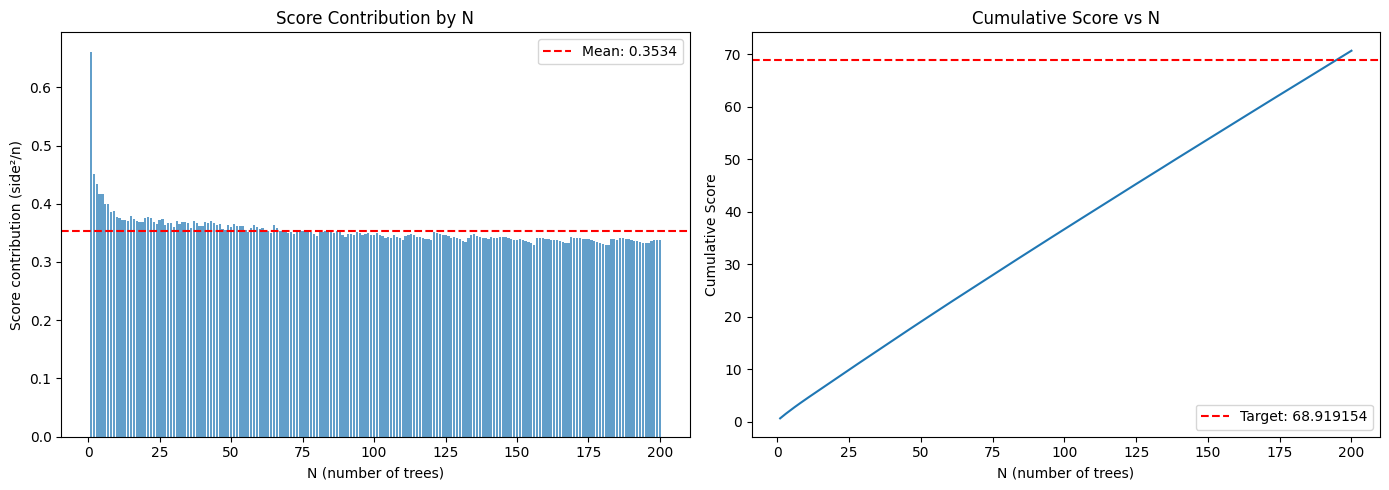

In [11]:
# Plot score contribution vs N
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(scores_df['n'], scores_df['score_contribution'], alpha=0.7)
axes[0].set_xlabel('N (number of trees)')
axes[0].set_ylabel('Score contribution (side²/n)')
axes[0].set_title('Score Contribution by N')
axes[0].axhline(y=scores_df['score_contribution'].mean(), color='r', linestyle='--', label=f'Mean: {scores_df["score_contribution"].mean():.4f}')
axes[0].legend()

axes[1].plot(scores_df['n'], scores_df['cumulative_score'])
axes[1].set_xlabel('N (number of trees)')
axes[1].set_ylabel('Cumulative Score')
axes[1].set_title('Cumulative Score vs N')
axes[1].axhline(y=68.919154, color='r', linestyle='--', label='Target: 68.919154')
axes[1].legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()

In [12]:
# Calculate theoretical minimum score if we could achieve perfect packing
# For a single tree, the minimum bounding box is achieved at 45 degrees
base = Polygon(TREE_VERTICES)
min_side_single = float('inf')
best_angle = 0
for angle in range(0, 360):
    rotated = rotate(base, angle, origin=(0, 0))
    coords = np.array(rotated.exterior.coords)
    side = max(coords.max(axis=0) - coords.min(axis=0))
    if side < min_side_single:
        min_side_single = side
        best_angle = angle

print(f'Single tree minimum bounding box side: {min_side_single:.6f} at angle {best_angle}°')
print(f'Single tree score contribution: {min_side_single**2:.6f}')
print(f'Current N=1 score: {scores_df[scores_df["n"]==1]["score_contribution"].values[0]:.6f}')

Single tree minimum bounding box side: 0.813173 at angle 45°
Single tree score contribution: 0.661250
Current N=1 score: 0.661250


In [13]:
# Summary of findings
print('='*60)
print('SUMMARY OF FINDINGS')
print('='*60)
print(f'Current best score: {scores_df["score_contribution"].sum():.6f}')
print(f'Target score: 68.919154')
print(f'Gap to close: {scores_df["score_contribution"].sum() - 68.919154:.6f}')
print()
print('Key observations:')
small_n_score = scores_df[scores_df['n']<=10]['score_contribution'].sum()
total_score = scores_df['score_contribution'].sum()
print(f'  - Small N (1-10) contributes {small_n_score:.4f} ({small_n_score/total_score*100:.1f}%)')
print(f'  - N=1 alone contributes {scores_df[scores_df["n"]==1]["score_contribution"].values[0]:.4f}')
print(f'  - Worst efficiency at N={int(scores_df.loc[scores_df["efficiency"].idxmax(), "n"])}')

In [ ]:
# Summary of findings
print('='*60)
print('SUMMARY OF FINDINGS')
print('='*60)
print(f'Current best score: {scores_df["score_contribution"].sum():.6f}')
print(f'Target score: 68.919154')
print(f'Gap to close: {scores_df["score_contribution"].sum() - 68.919154:.6f}')
print(f'\nKey observations:')
print(f'  - Small N (1-10) contributes {scores_df[scores_df["n"]<=10]["score_contribution"].sum():.4f} ({scores_df[scores_df["n"]<=10]["score_contribution"].sum()/scores_df["score_contribution"].sum()*100:.1f}%)')
print(f'  - N=1 alone contributes {scores_df[scores_df["n"]==1]["score_contribution"].values[0]:.4f}')
print(f'  - Worst efficiency at N={scores_df.loc[scores_df["efficiency"].idxmax(), "n"]}')
print(f'\nStrategic implications:')
print(f'  - Focus on small N values for biggest impact')
print(f'  - Need ~{(scores_df["score_contribution"].sum() - 68.919154)/scores_df["score_contribution"].sum()*100:.1f}% improvement overall')